In [1]:
%matplotlib inline
import random
import itertools

import matplotlib.pyplot as plt
import numpy as np

import soli_start
from reviews_soli import ReviewsSolicitation
from data_model import Feature
import uncertainty

file_path = 'datasets/edmunds_reviews.csv'
dataset_profile = soli_start.probe_dataset(file_path)
print(dataset_profile)

Dataset of 5 stars, with 501 products and 53440 reviews
average of feature_rating_count/product = 105.867



Statistics of #reviews/product: min=1, max=1294, average=106.667, std=148.622, median=52.0


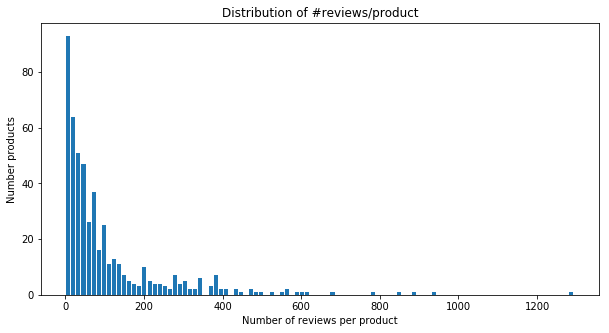

In [2]:
# Distribution of #reviews/product
temp = dataset_profile.per_product_review_counts
print('Statistics of #reviews/product: min={min}, max={max}'
      ', average={average:.3f}, std={std:.3f}, median={median}' \
      .format(min=np.amin(temp), max=np.amax(temp),
              average=np.average(temp), std=np.std(temp), median=np.median(temp)))

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(dataset_profile.per_product_review_counts, bins=100, rwidth=0.8)
ax.set_xlabel('Number of reviews per product')
ax.set_ylabel('Number products')
ax.set_title('Distribution of #reviews/product')
plt.show()

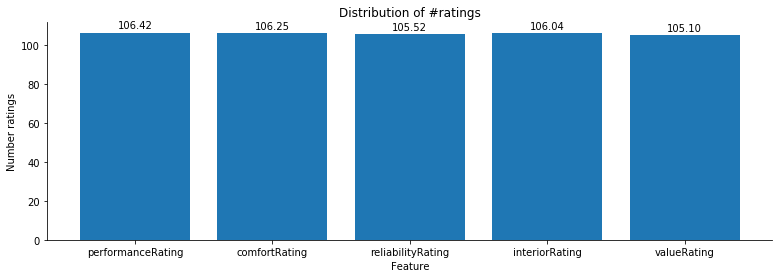

In [3]:
# Distribution of #feature_rating/product
fig, ax = plt.subplots(figsize=(13, 4))
features = list(dataset_profile.feature_to_review_count_average.keys())
num_ratings = list(dataset_profile.feature_to_review_count_average.values())
x_pos = np.arange(len(features))
rects = ax.bar(x_pos, num_ratings)

ax.set_xlabel('Feature')
ax.set_ylabel('Number ratings')
ax.set_title('Distribution of #ratings')
ax.set_xticks(x_pos)
ax.set_xticklabels(features)

for rect, num_rating in zip(rects, num_ratings):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.01*height,
            '{:.2f}'.format(num_rating), ha='center', va='bottom')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [ ]:
def plot_pick_answer_methods(pick_answer_to_sim_stats):
    sim_stats_sample = list(pick_answer_to_sim_stats.values())[0]
    metrics = sim_stats_sample.uncertainty_reports[0].metrics()
    
    X = list(sim_stats_sample.polls)
    for metric in metrics:
        #fig, ax = plt.subplots(figsize=(12, 7))
        fig, axarr = plt.subplots(1, 2, figsize=(18, 7),
                                  sharex=True, sharey=True,
                                  subplot_kw=dict(title='Cost change over polls',
                                                  xlabel='Number of polls',
                                                  ylabel=metric))
        
        for pick_answer_method, sim_stats in pick_answer_to_sim_stats.items():           
            Y = [report.get_metric(metric) for report in sim_stats.uncertainty_reports]
            pick_method, answer_method = pick_answer_method
            if answer_method.endswith('_gen'):
                axarr[1].plot(X, Y, label=pick_answer_method)
            else:
                axarr[0].plot(X, Y, label=pick_answer_method)

        for ax in axarr:
            ax.legend(loc='upper right')
        plt.show()

def plot_no_answer_count(pick_answer_to_sim_stats):
    no_answer_counts = [stat.no_answer_count
                        for stat in pick_answer_to_sim_stats.values()]
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw={'title':'No answer count',
                                                       'xlabel':'#No answer'})
    y_pos = np.arange(len(pick_answer_to_sim_stats))
    rects = ax.barh(y_pos, no_answer_counts, align='center')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(pick_answer_to_sim_stats.keys())

    for rect, count in zip(rects, no_answer_counts):
        ax.text(rect.get_x() + rect.get_width() + 5,
                rect.get_y() + rect.get_height()/2,
                count, ha='right', va='center')
    plt.show()

In [ ]:
import json

weightings = [True]
correlatings = [True]
review_count_lowbound = 950
poll_count = 100
question_count = 2
confidence_level = 0.95

optim_goal_to_product_result_stats = {}
for criterion, weighting, correlating in uncertainty.uncertainty_metrics:                                                                                                                               
    if criterion == 'confidence_interval_len':
        continue
    product_to_result_stats = soli_start.simulate_reviews_soli(
        file_path,
        poll_count=poll_count, question_count=question_count,
        review_count_lowbound=review_count_lowbound,
        criterion=criterion, weighting=weighting, correlating=correlating,
        dataset_profile=dataset_profile,
        confidence_level=confidence_level)
    
    optim_goal_to_product_result_stats[(criterion, weighting, correlating)] = \
        product_to_result_stats

with open('data.json', 'w') as f:
    json.dumps(optim_goal_to_product_result_stats, f)
print('Done with simulation, wait for plots ')

/home/nhat/workspace/reviews-solicitation/reviews_soli.py:167: RuntimeWarning: invalid value encountered in true_divide
  np.sum(self.uncertainty_book.uncertainties)
/home/nhat/workspace/reviews-solicitation/reviews_soli.py:169: RuntimeWarning: invalid value encountered in less
  picked_feature = np.random.choice(self.features, p=weights)


In [ ]:
product = None
for optim_goal, product_to_result_stats in optim_goal_to_product_result_stats.items():
    if not product:
        product = random.choice(list(product_to_result_stats.keys()))
        print('Product: {}\n'.format(product))

    print('Experiment with optimization goal: {}'.format(str(optim_goal)))
    pick_answer_to_sim_stats = product_to_result_stats[product]

    plot_no_answer_count(pick_answer_to_sim_stats)
    
    plot_pick_answer_methods(pick_answer_to_sim_stats)